# Categorical VAE with Gumbel-Softmax

## 1. Environment Setup
### 1.0. Check GPU

In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


### 1.1. Install Pytorch and torchvision

In [2]:
!pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio===0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


### 1.2. Import

In [3]:
import dataset, train, torch, torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms

# Ignore Warning
import warnings
warnings.filterwarnings(action='ignore')

In [4]:
# If something wrong with CUDA, more details are provided
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

## 2. Data Preprocessing

In [5]:
batch_size = 100

In [6]:
transform = transforms.Compose([transforms.PILToTensor()])
#transform = transforms.Compose([transforms.ToTensor()])

train_dataset = dataset.MNIST_dataset('../Dataset/Binarized_MNIST/dataset/train/', transform=transform)
valid_dataset = dataset.MNIST_dataset('../Dataset/Binarized_MNIST/dataset/valid/', transform=transform)
test_dataset = dataset.MNIST_dataset('../Dataset/Binarized_MNIST/dataset/test/', transform=transform)

trainval_dataset = torch.utils.data.ConcatDataset([train_dataset, valid_dataset])

trainloader = torch.utils.data.DataLoader(trainval_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

## 3. Train Model

In [7]:
img_dim = 28*28

K = 10 # number of classes
N = 20 # number of categorical distributions
temperature = 2/3
init_weights = True

gpu_id = 4
print_freq = 200
epoch_print = 20

epochs = 201

lr = 0.0003
weight_decay = 0

In [8]:
Gumbel_Softmax_VAE = train.Gumbel_Softmax_VAE(img_dim=img_dim, K=K, N=N, temperature=temperature, init_weights=init_weights, 
                                              gpu_id=gpu_id, print_freq=print_freq, epoch_print=epoch_print)

In [9]:
Gumbel_Softmax_VAE.train(train_data=trainloader, test_data=testloader, epochs=epochs, lr=lr, weight_decay=weight_decay)

Epoch 1 Started...
Iteration : 200 - Train Loss : 192.6630, Test Loss : 197.3295
Iteration : 400 - Train Loss : 146.7796, Test Loss : 164.3975
Iteration : 600 - Train Loss : 142.4182, Test Loss : 153.1187
Epoch 21 Started...
Iteration : 200 - Train Loss : 106.9491, Test Loss : 119.8706
Iteration : 400 - Train Loss : 106.1815, Test Loss : 120.1429
Iteration : 600 - Train Loss : 100.8194, Test Loss : 119.9245
Epoch 41 Started...
Iteration : 200 - Train Loss : 102.1094, Test Loss : 115.2726
Iteration : 400 - Train Loss : 101.4190, Test Loss : 115.6674
Iteration : 600 - Train Loss : 100.3622, Test Loss : 115.2109
Epoch 61 Started...
Iteration : 200 - Train Loss : 95.8588, Test Loss : 112.0001
Iteration : 400 - Train Loss : 94.9194, Test Loss : 111.8548
Iteration : 600 - Train Loss : 92.2210, Test Loss : 111.6819
Epoch 81 Started...
Iteration : 200 - Train Loss : 94.0764, Test Loss : 109.7447
Iteration : 400 - Train Loss : 92.0598, Test Loss : 109.2007
Iteration : 600 - Train Loss : 93.3990

## 4. Unconditional Generation

In [10]:
generate_num = 10

Z = torch.randint(0, K, (generate_num ** 2, N))
Z = F.one_hot(Z, K).view(generate_num ** 2, -1)

In [11]:
Gumbel_Softmax_VAE = Gumbel_Softmax_VAE.model.cpu()

Gumbel_Softmax_VAE.eval()
with torch.no_grad():
    generate = Gumbel_Softmax_VAE.decoder(Z.float()).view(generate_num ** 2, 28, 28)

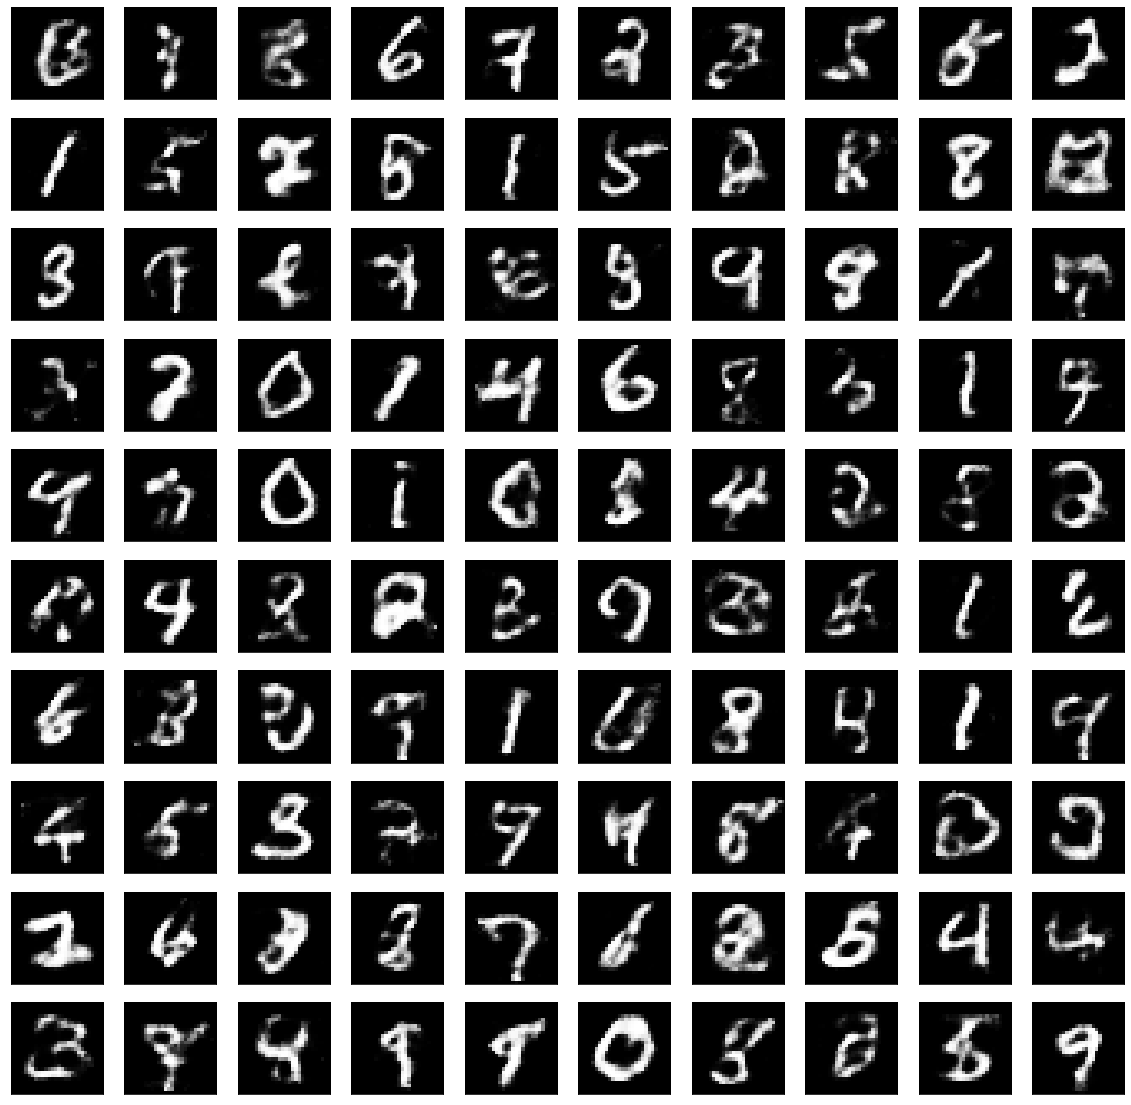

In [12]:
plt.figure(figsize=(20, 20))
plt.axis('off')

for i in range(generate.size(0)):
    plt.subplot(generate_num, generate_num, i+1)
    img = plt.imshow(generate[i], cmap=plt.cm.gray); img.axes.get_xaxis().set_visible(False); img.axes.get_yaxis().set_visible(False)